In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os 
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import pydot

In [2]:
train_dir = 'train_frames'
test_dir = 'test_frames'

In [3]:
#Datasets parameters
BATCH_SIZE = 32
IMG_SIZE = (227,227)

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7850 files belonging to 11 classes.


2023-03-14 01:23:02.778120: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 01:23:02.778195: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 01:23:02.778227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hena029): /proc/driver/nvidia/version does not exist
2023-03-14 01:23:02.778626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 7589 files belonging to 11 classes.


In [5]:
#Configure dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [68]:
test_dataset1 = test_datagen.flow_from_directory(test_dir,IMG_SIZE,shuffle=True,
                                                batch_size=BATCH_SIZE,class_mode='categorical' )

Found 7589 images belonging to 11 classes.


In [8]:
#Use data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [9]:
path = 'train_frames'
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path, target_size=(227,227), class_mode='categorical')

Found 7850 images belonging to 11 classes.


In [10]:
print("Batch Size for Input Image : ",train[0][0].shape)
print("Batch Size for Output Image : ",train[0][1].shape)
print("Image Size of first image : ",train[0][0][0].shape)
print("Output of first image : ",train[0][1][0].shape)

Batch Size for Input Image :  (32, 227, 227, 3)
Batch Size for Output Image :  (32, 11)
Image Size of first image :  (227, 227, 3)
Output of first image :  (11,)


/home/hena/.local/lib/python3.10/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]')

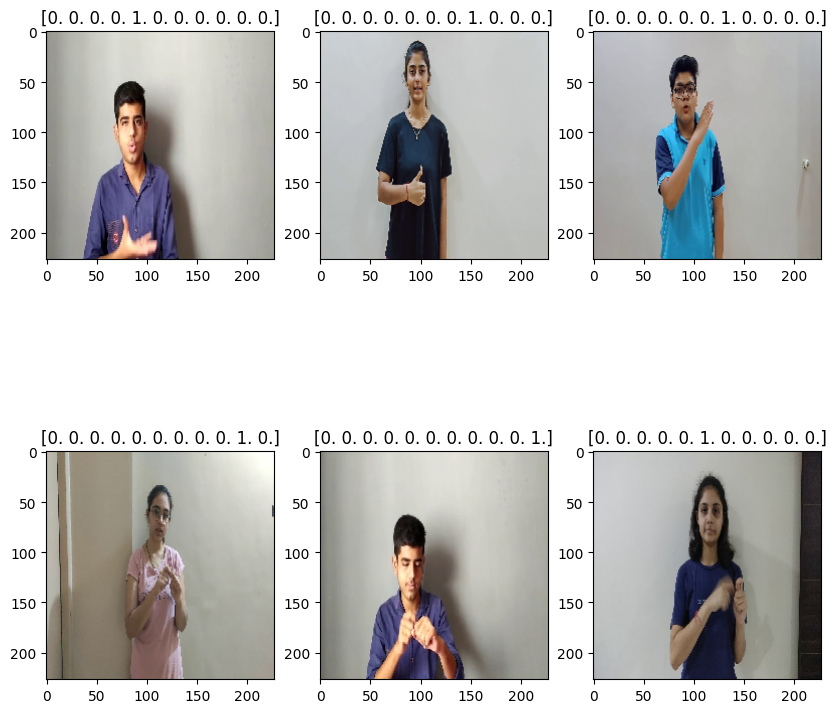

In [11]:
fig , axs = plt.subplots(2,3 ,figsize = (10,10))
axs[0][0].imshow(train[0][0][12])
axs[0][0].set_title(train[0][1][12])
axs[0][1].imshow(train[0][0][9])
axs[0][1].set_title(train[0][1][10])
axs[0][2].imshow(train[0][0][5])
axs[0][2].set_title(train[0][1][5])
axs[1][0].imshow(train[0][0][20])
axs[1][0].set_title(train[0][1][20])
axs[1][1].imshow(train[0][0][25])
axs[1][1].set_title(train[0][1][22])
axs[1][2].imshow(train[0][0][13])
axs[1][2].set_title(train[0][1][3])

In [12]:
#Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-03-14 01:23:43.446252: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 53231616 exceeds 10% of free system memory.
2023-03-14 01:23:43.618488: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 53231616 exceeds 10% of free system memory.
2023-03-14 01:23:43.668938: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 53231616 exceeds 10% of free system memory.
2023-03-14 01:23:43.733164: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 53231616 exceeds 10% of free system memory.
2023-03-14 01:23:43.863338: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 53231616 exceeds 10% of free system memory.


(32, 8, 8, 1280)


In [15]:
base_model.trainable = False

In [16]:
print(base_model.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 114, 114, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 114, 114, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 57, 57, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 59, 59, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 29, 29, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 29, 29, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 15, 15, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 15, 15, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 15, 15, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 15, 15, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 15, 15, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 15, 15, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 15, 15, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 15, 15, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

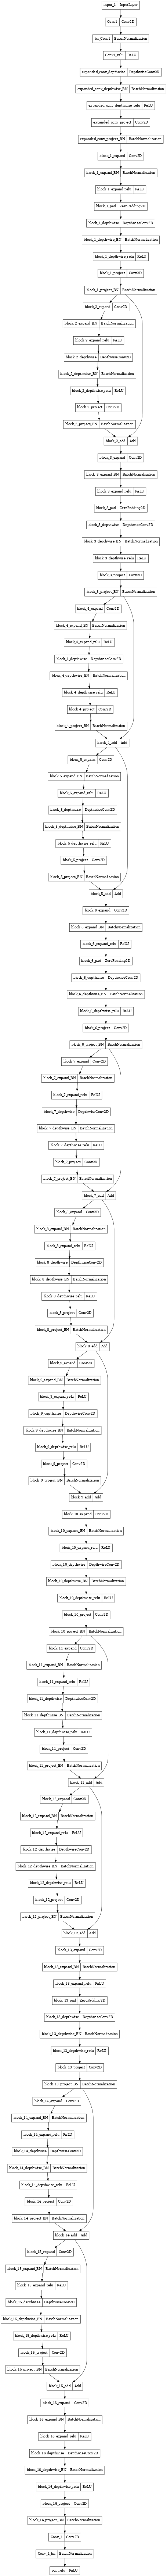

In [17]:
tf.keras.utils.plot_model(
    base_model, to_file='mobilenet.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=45
)

In [18]:
#Classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(100, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 100)


In [20]:

inputs = tf.keras.Input(shape=(227, 227, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
#compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 227, 227, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 227, 227, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

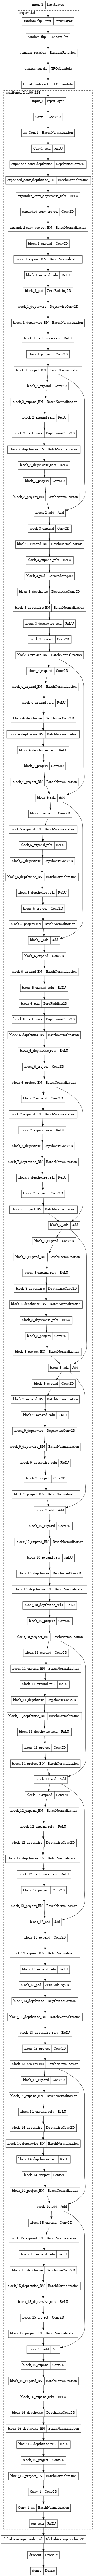

In [40]:
tf.keras.utils.plot_model(
    model, to_file='mobilenet_modified.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=45
)

In [23]:
initial_epochs = 30
loss0, accuracy0 = model.evaluate(test_dataset)

/home/hena/.local/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


238/238 [==============================] - 289s 1s/step - loss: 4.7616 - accuracy: 0.0300


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 4.76
initial accuracy: 0.03


In [25]:
initial_epochs = 30
loss0, accuracy0 = model.evaluate(train_dataset)

246/246 [==============================] - 224s 900ms/step - loss: 4.7566 - accuracy: 0.0293


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.76
initial accuracy: 0.03


In [28]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=test_dataset)

Epoch 1/30
246/246 [==============================] - 474s 2s/step - loss: 2.7882 - accuracy: 0.1115 - val_loss: 2.4301 - val_accuracy: 0.1644
Epoch 2/30
246/246 [==============================] - 470s 2s/step - loss: 2.3832 - accuracy: 0.1697 - val_loss: 2.3038 - val_accuracy: 0.2253
Epoch 3/30
246/246 [==============================] - 460s 2s/step - loss: 2.2552 - accuracy: 0.2176 - val_loss: 2.2018 - val_accuracy: 0.2737
Epoch 4/30
246/246 [==============================] - 432s 2s/step - loss: 2.1476 - accuracy: 0.2693 - val_loss: 2.1225 - val_accuracy: 0.3008
Epoch 5/30
246/246 [==============================] - 430s 2s/step - loss: 2.0747 - accuracy: 0.2975 - val_loss: 2.0470 - val_accuracy: 0.3259
Epoch 6/30
246/246 [==============================] - 430s 2s/step - loss: 1.9974 - accuracy: 0.3343 - val_loss: 1.9880 - val_accuracy: 0.3558
Epoch 7/30
246/246 [==============================] - 436s 2s/step - loss: 1.9259 - accuracy: 0.3693 - val_loss: 1.9399 - val_accuracy: 0.3624

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

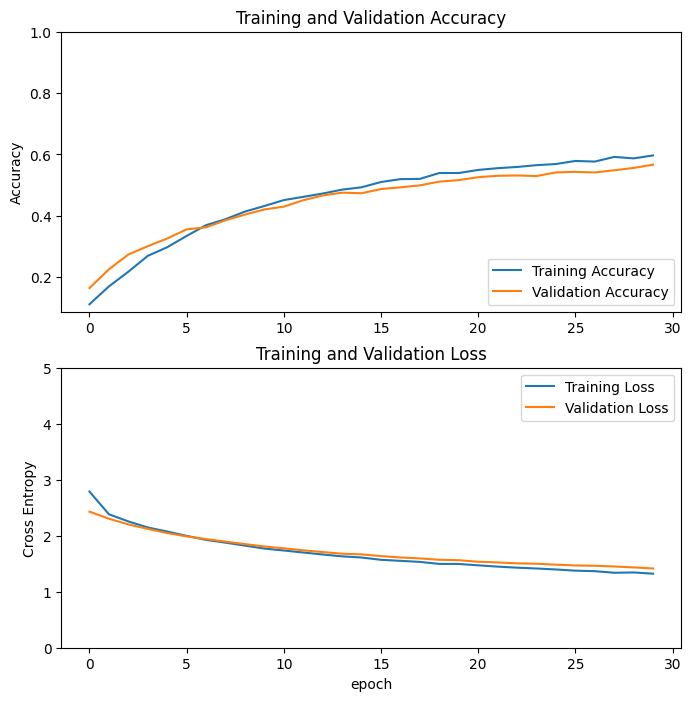

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
base_model.trainable = True

In [44]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [45]:
fine_tune_at = 100

In [46]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [47]:
#Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 227, 227, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 227, 227, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

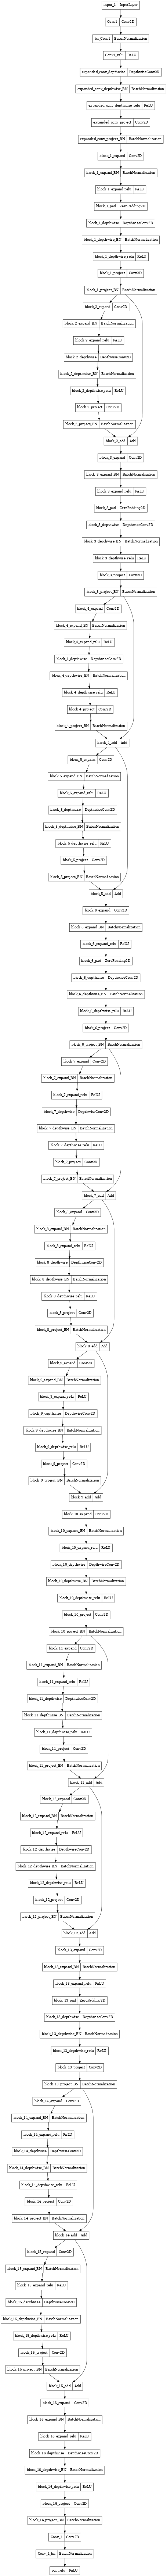

In [48]:
tf.keras.utils.plot_model(
    base_model, to_file='mobilenet_finetuning.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=45
)

In [49]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

In [38]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 30/60
246/246 [==============================] - 645s 2s/step - loss: 1.1885 - accuracy: 0.6229 - val_loss: 1.1583 - val_accuracy: 0.6154
Epoch 31/60
246/246 [==============================] - ETA: 0s - loss: 0.9693 - accuracy: 0.7017

2023-03-14 18:58:59.186243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 124 of 256
2023-03-14 18:59:01.647592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 583s 2s/step - loss: 0.9693 - accuracy: 0.7017 - val_loss: 1.0113 - val_accuracy: 0.6636
Epoch 32/60
246/246 [==============================] - ETA: 0s - loss: 0.8379 - accuracy: 0.7377

2023-03-14 19:09:14.504389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 252 of 256
2023-03-14 19:09:14.504539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 614s 2s/step - loss: 0.8379 - accuracy: 0.7377 - val_loss: 0.9950 - val_accuracy: 0.6619
Epoch 33/60
246/246 [==============================] - 608s 2s/step - loss: 0.7243 - accuracy: 0.7801 - val_loss: 0.7999 - val_accuracy: 0.7365
Epoch 34/60
246/246 [==============================] - 607s 2s/step - loss: 0.6400 - accuracy: 0.8051 - val_loss: 0.7154 - val_accuracy: 0.7651
Epoch 35/60
246/246 [==============================] - 588s 2s/step - loss: 0.5535 - accuracy: 0.8354 - val_loss: 0.6054 - val_accuracy: 0.8088
Epoch 36/60
246/246 [==============================] - 602s 2s/step - loss: 0.4860 - accuracy: 0.8550 - val_loss: 0.5984 - val_accuracy: 0.8000
Epoch 37/60
246/246 [==============================] - 650s 3s/step - loss: 0.4409 - accuracy: 0.8684 - val_loss: 0.4840 - val_accuracy: 0.8533
Epoch 38/60
246/246 [==============================] - 663s 3s/step - loss: 0.3935 - accuracy: 0.8832 - val_loss: 0.4835 - val_accuracy: 0.8497
Epoc

2023-03-14 23:40:59.188440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 155 of 256
2023-03-14 23:41:06.423012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


246/246 [==============================] - 621s 2s/step - loss: 0.0779 - accuracy: 0.9803 - val_loss: 0.0948 - val_accuracy: 0.9754
Epoch 58/60
246/246 [==============================] - 562s 2s/step - loss: 0.0732 - accuracy: 0.9806 - val_loss: 0.1640 - val_accuracy: 0.9418
Epoch 59/60
246/246 [==============================] - 592s 2s/step - loss: 0.0666 - accuracy: 0.9811 - val_loss: 0.0960 - val_accuracy: 0.9734
Epoch 60/60
246/246 [==============================] - 657s 3s/step - loss: 0.0674 - accuracy: 0.9814 - val_loss: 0.0965 - val_accuracy: 0.9707


In [50]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

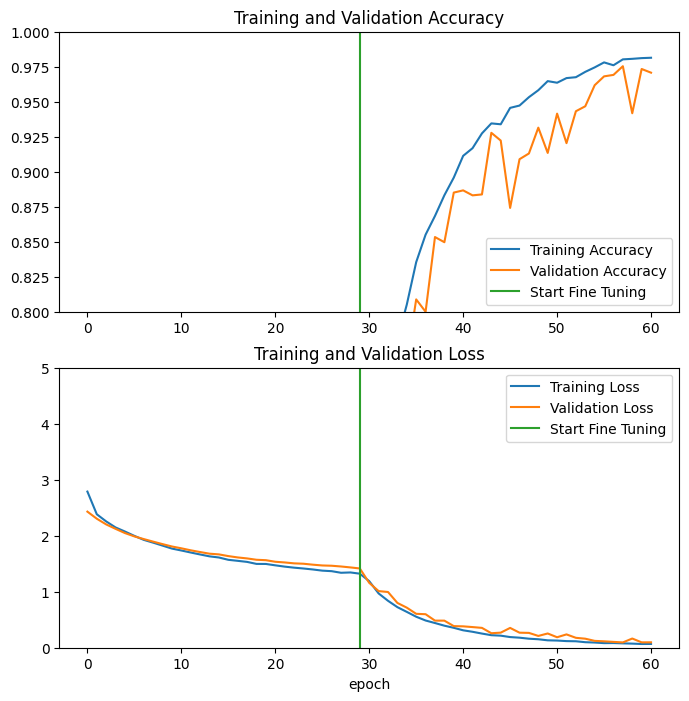

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [54]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dataset = test_datagen.flow_from_directory(test_dir,IMG_SIZE,shuffle=True,
                                                batch_size=BATCH_SIZE,class_mode='categorical' )

Found 7589 images belonging to 11 classes.


In [55]:
Y_pred = model.predict(test_dataset)

238/238 [==============================] - 247s 868ms/step


In [60]:
y_pred = np.argmax(Y_pred, axis=1)

In [61]:
cm = confusion_matrix(test_dataset.classes, y_pred)

In [64]:
print(cm)

[[  0   0   0   0 691   0   0   0   0   0   0]
 [  0   0   0   0 653   0   0   0   0   0   0]
 [  0   0   0   0 694   0   0   0   0   0   0]
 [  0   0   0   0 683   0   0   0   0   0   0]
 [  0   0   0   0 671   0   0   0   0   0   0]
 [  0   0   0   0 755   0   0   0   0   0   0]
 [  0   0   0   0 572   0   0   0   0   0   0]
 [  0   0   0   0 713   0   0   0   0   0   0]
 [  0   0   0   0 690   0   0   0   0   0   0]
 [  0   0   0   0 740   0   0   0   0   0   0]
 [  0   0   0   0 727   0   0   0   0   0   0]]


In [65]:
labels=['Bye','Work ','House','No','Nice','Good','Yes ','Hello','Thank You','Morning','Welcome ']

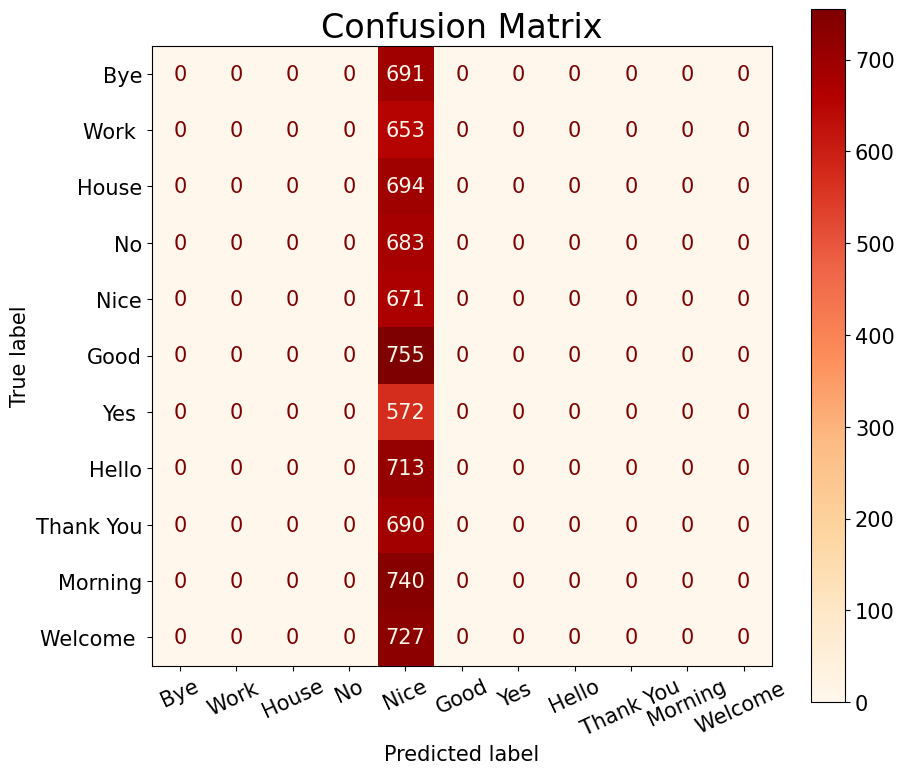

In [66]:
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 15
display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=24)
plt.savefig('confusion_matrix_MobileNet.png', transparent=True, dpi=400)
plt.show()